In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load


from time import time
from collections import Counter

import tqdm
from tqdm import tqdm

import pyarrow

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
azdias = pd.read_csv('./data/cleaned/azdias_subset.csv')
azdias.head()

,LNR,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,1.675853,15.296686,3.591198,1.276344,1.539922,1.068679,4.152935,44,2.0,...,1.0,1.590325,1.31521,1.511706,4.145629,7.912491,4.050562,3.0,1.0,2.0
1,910220,1.675853,15.296686,3.591198,1.276344,2.000000,1.068679,6.000000,35,5.0,...,1.0,3.000000,1.31521,2.000000,3.000000,9.000000,4.000000,5.0,2.0,1.0
2,910225,1.675853,17.000000,10.000000,1.276344,1.000000,1.068679,2.000000,15,3.0,...,4.0,2.000000,1.31521,1.000000,3.000000,9.000000,2.000000,5.0,2.0,3.0
3,910226,2.000000,13.000000,1.000000,1.276344,1.539922,1.068679,4.000000,5,2.0,...,4.0,1.000000,1.31521,1.000000,4.145629,9.000000,7.000000,3.0,2.0,4.0
4,910241,1.675853,20.000000,3.000000,1.276344,1.539922,1.068679,2.000000,25,5.0,...,7.0,2.000000,1.31521,2.000000,2.000000,9.000000,3.000000,4.0,1.0,3.0


In [3]:
azdias = azdias.drop('LNR', axis=1)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638400 entries, 0 to 638399
Columns: 271 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(247), int64(24)
memory usage: 1.3 GB


In [4]:
def pca_results(full_dataset, pca, show_plot=True):
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance Ratio'])
    variance_ratios.index = dimensions
    cumsum = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1)
    variance_cumsum = pd.DataFrame(np.round(cumsum, 4), columns = ['Explained Cumulative Variance'])
    variance_cumsum.index = dimensions

    if show_plot == True:
        fig, ax = plt.subplots(figsize = (14,8))
        ax.plot(np.arange(len(variance_cumsum)), variance_cumsum)
        ax.set_ylabel("Explained Cum. Variance")
        ax.set_xlabel("Num. of Principal Comp.")
    return pd.concat([variance_cumsum, variance_ratios, components], axis = 1)

def print_pcs(df, pca, comp, k=5):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    pc = components.iloc[comp-1].sort_values(ascending=False)
    print(f'Weights for PC{comp}')
    print(f'Top {k} weights')
    print(pc.head(k))
    print('\n')
    print(f'Bottom {k} weights')
    print(pc.tail(k))

def comp_weights(pca, dimension_max, dimension_min , num_features, df):
    components = pd.DataFrame( np.round(pca.components_, 4), columns = df.keys())
    components.index = [i for i in range(1, len(pca.components_)+1)]

    weights_pos = components.iloc[dimension_max-1]
    weights_neg = components.iloc[dimension_min-1]
    fig, ax = plt.subplots(figsize = (15, 4), ncols=2, nrows = 1)
    weights_pos.sort_values(ascending=False)[:num_features].plot(kind='bar', ax = ax[0]);
    weights_neg.sort_values(ascending=False)[-num_features:].plot(kind='bar', ax = ax[1], color = 'red');
    
    return fig

# PCA

In [5]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.675853,15.296686,3.591198,1.276344,1.539922,1.068679,4.152935,44,2.0,0,...,1.0,1.590325,1.31521,1.511706,4.145629,7.912491,4.050562,3.0,1.0,2.0
1,1.675853,15.296686,3.591198,1.276344,2.000000,1.068679,6.000000,35,5.0,0,...,1.0,3.000000,1.31521,2.000000,3.000000,9.000000,4.000000,5.0,2.0,1.0
2,1.675853,17.000000,10.000000,1.276344,1.000000,1.068679,2.000000,15,3.0,0,...,4.0,2.000000,1.31521,1.000000,3.000000,9.000000,2.000000,5.0,2.0,3.0
3,2.000000,13.000000,1.000000,1.276344,1.539922,1.068679,4.000000,5,2.0,0,...,4.0,1.000000,1.31521,1.000000,4.145629,9.000000,7.000000,3.0,2.0,4.0
4,1.675853,20.000000,3.000000,1.276344,1.539922,1.068679,2.000000,25,5.0,3,...,7.0,2.000000,1.31521,2.000000,2.000000,9.000000,3.000000,4.0,1.0,3.0


In [7]:
#SCALE DATAFRAME
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
azdias_scaled = scaler.fit_transform(azdias)

In [8]:
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns=azdias.columns)

In [9]:
azdias_scaled_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.558618,0.714834,0.287911,0.030705,0.269961,0.013736,0.525489,1.000000,0.2,0.0,...,0.0,0.530108,0.078803,0.511706,0.629126,0.864061,0.50632,0.4,0.0,0.125
1,0.558618,0.714834,0.287911,0.030705,0.500000,0.013736,0.833333,0.795455,0.8,0.0,...,0.0,1.000000,0.078803,1.000000,0.400000,1.000000,0.50000,0.8,1.0,0.000
2,0.558618,0.800000,1.000000,0.030705,0.000000,0.013736,0.166667,0.340909,0.4,0.0,...,0.5,0.666667,0.078803,0.000000,0.400000,1.000000,0.25000,0.8,1.0,0.250
3,0.666667,0.600000,0.000000,0.030705,0.269961,0.013736,0.500000,0.113636,0.2,0.0,...,0.5,0.333333,0.078803,0.000000,0.629126,1.000000,0.87500,0.4,1.0,0.375
4,0.558618,0.950000,0.222222,0.030705,0.269961,0.013736,0.166667,0.568182,0.8,0.5,...,1.0,0.666667,0.078803,1.000000,0.200000,1.000000,0.37500,0.6,0.0,0.250


In [10]:
pca = PCA(random_state=777)
pca.fit(azdias_scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=777,
    svd_solver='auto', tol=0.0, whiten=False)

,Explained Cumulative Variance,Explained Variance Ratio,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Dimension 1,0.0920,0.0920,-0.0051,0.0131,-0.1091,-0.0001,0.0938,0.0000,0.0766,-0.1445,...,0.0438,-0.0032,0.0000,-0.0304,-0.0795,0.0190,0.0306,-0.0876,-0.0170,0.0128
Dimension 2,0.1496,0.0576,0.0011,-0.0400,0.0088,0.0005,-0.0566,-0.0000,-0.0978,-0.0212,...,-0.0088,0.0349,0.0000,0.0381,0.0833,0.0122,-0.0624,-0.0169,0.0178,0.0259
Dimension 3,0.2021,0.0525,0.0070,0.0736,0.0311,-0.0001,0.0469,0.0000,-0.0974,0.0267,...,-0.0164,-0.0267,-0.0000,0.0096,-0.1124,-0.0510,-0.0460,0.0332,-0.0009,-0.0672
Dimension 4,0.2438,0.0417,-0.0007,-0.0402,0.0183,0.0002,0.0587,0.0000,-0.0855,0.0042,...,0.0374,0.0822,0.0001,0.0435,0.0094,0.0189,-0.0546,-0.0279,0.0571,0.0689
Dimension 5,0.2820,0.0382,0.0003,-0.0087,-0.0036,-0.0000,-0.0010,-0.0000,-0.0244,-0.0155,...,0.3360,-0.1372,-0.0000,0.0125,0.0497,0.0050,-0.0071,-0.0250,-0.5294,0.0020
Dimension 6,0.3091,0.0271,0.0022,0.0087,-0.0073,0.0002,0.0160,-0.0000,0.0231,0.0010,...,-0.0082,0.0167,0.0001,-0.0409,-0.0173,-0.0017,-0.0430,-0.0131,-0.0038,-0.0270
Dimension 7,0.3326,0.0235,0.0029,-0.0258,0.0552,0.0000,-0.2122,-0.0000,0.0595,-0.0613,...,0.0513,-0.0116,-0.0000,-0.0162,0.1392,-0.0720,0.0169,0.0433,-0.0021,0.0011
Dimension 8,0.3547,0.0221,0.0052,0.0124,-0.0078,-0.0001,0.0958,0.0000,-0.0944,-0.0014,...,-0.0015,0.0142,0.0000,0.0210,-0.0507,0.0253,-0.0804,-0.0363,-0.0056,-0.0148
Dimension 9,0.3750,0.0203,-0.0018,0.0122,0.0359,-0.0000,0.1503,0.0000,0.0537,0.0179,...,0.0071,-0.0075,-0.0000,-0.0168,-0.0945,0.0454,0.0436,0.0002,-0.0171,0.0176
Dimension 10,0.3933,0.0182,0.0008,-0.0027,-0.0529,-0.0002,-0.0254,0.0000,0.0213,0.0175,...,-0.0229,0.0222,-0.0000,-0.0634,0.0210,-0.0026,0.0612,-0.0335,0.0146,0.0023


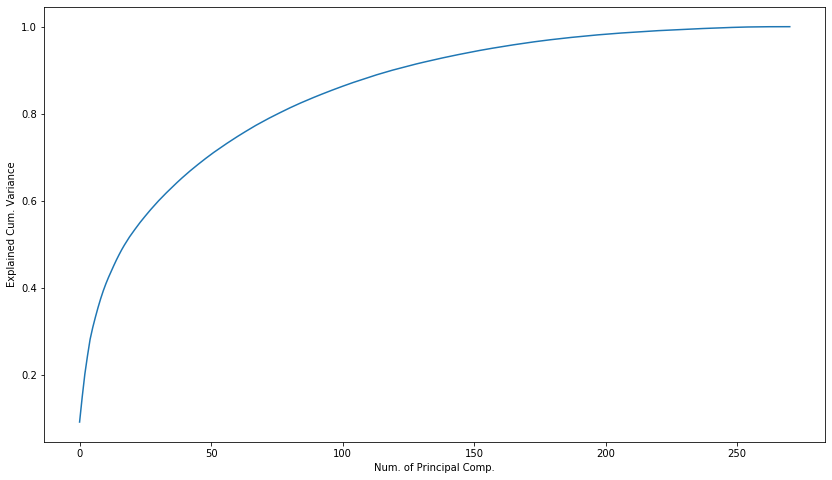

In [11]:
results = pca_results(azdias_scaled_df, pca)
results

In [72]:
n_components = 220
explained_variance = results.iloc[n_components, 0]
explained_variance

0.9909

In [73]:
pca = PCA(n_components=n_components, random_state=777)
azdias_pca = pca.fit_transform(azdias_scaled_df)

In [74]:
for index in range(1,3):
    print_pcs(azdias_scaled_df, pca, comp=index)

Weights for PC1
Top 5 weights
LP_STATUS_FEIN       0.2102
LP_STATUS_GROB       0.2027
KBA05_ANTG1          0.1749
KBA05_GBZ            0.1549
FINANZ_MINIMALIST    0.1493
Name: 0, dtype: float64


Bottom 5 weights
HH_EINKOMMEN_SCORE   -0.1485
FINANZ_HAUSBAUER     -0.1494
PLZ8_ANTG3           -0.1533
PLZ8_BAUMAX          -0.1614
PLZ8_ANTG4           -0.1641
Name: 0, dtype: float64
Weights for PC2
Top 5 weights
KBA13_HERST_BMW_BENZ    0.1525
OST_WEST_KZ             0.1480
KBA13_CCM_3001          0.1382
KBA13_SEG_SPORTWAGEN    0.1362
KBA13_KMH_211           0.1310
Name: 1, dtype: float64


Bottom 5 weights
KBA13_SEG_KLEINWAGEN          -0.1075
D19_VERSAND_ONLINE_QUOTE_12   -0.1113
D19_GESAMT_ONLINE_QUOTE_12    -0.1142
KBA13_SITZE_5                 -0.1292
FINANZ_ANLEGER                -0.1380
Name: 1, dtype: float64


In [75]:
dump(pca, 'dump/pca.joblib')

['dump/pca.joblib']

# CLUSTERING

In [76]:
scores = []
clusters = list(range(2,50,1))
for k in clusters:
    print(f'KMeans with {k} cluster')
    start = time() 
    kmeans = KMeans(n_clusters = k, random_state=785, n_jobs=-1)
    model = kmeans.fit(azdias_pca)
    score = model.score(azdias_pca)
    scores.append(np.abs(score))
    end = time()
    m, s = divmod(end - start, 60)
    print(f'Finished KMeans with {k} cluster(s) in {m}m:{s}s with a score of {score}')

KMeans with 2 cluster
Finished KMeans with 2 cluster(s) in 1.0m:8.009143114089966s with a score of -11621039.515851477
KMeans with 3 cluster
Finished KMeans with 3 cluster(s) in 1.0m:4.6471171379089355s with a score of -11248557.448152
KMeans with 4 cluster
Finished KMeans with 4 cluster(s) in 1.0m:10.911978006362915s with a score of -10966431.365633952
KMeans with 5 cluster
Finished KMeans with 5 cluster(s) in 1.0m:16.420987606048584s with a score of -10747743.1565719
KMeans with 6 cluster
Finished KMeans with 6 cluster(s) in 1.0m:11.023001432418823s with a score of -10578686.252328075
KMeans with 7 cluster
Finished KMeans with 7 cluster(s) in 1.0m:45.05859303474426s with a score of -10428798.217207856
KMeans with 8 cluster
Finished KMeans with 8 cluster(s) in 2.0m:48.47932505607605s with a score of -10319124.502258819
KMeans with 9 cluster
Finished KMeans with 9 cluster(s) in 2.0m:41.01785087585449s with a score of -10219242.945142265
KMeans with 10 cluster
Finished KMeans with 10 cl

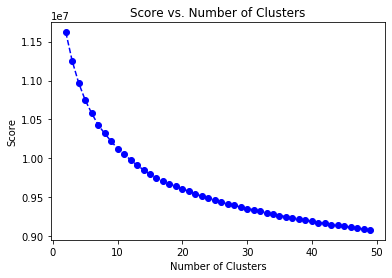

In [77]:
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of Clusters');
plt.ylabel('Score');
plt.title('Score vs. Number of Clusters')
plt.savefig('./assets/kmeans.png')
plt.show()

In [160]:
kmeans = KMeans(n_clusters = 15, random_state=777, n_jobs=-1)
kmeans = kmeans.fit(azdias_pca)

In [161]:
population_labels = kmeans.labels_

In [162]:
dump(kmeans, './dump/kmeans_model.joblib')

['./dump/kmeans_model.joblib']

# CUSTOMERS

In [118]:
feat_df = pd.read_csv('./data/AZDIAS_Feature_Summary_r003.csv')

cat_feats = ['CAMEO_DEU_2015','OST_WEST_KZ']
range_feats = ['GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','MIN_GEBAEUDEJAHR']

feats = list(set(feat_df['Attribute']))
num_feats = [feat for feat in feats if feat not in cat_feats+range_feats]

all_feats = cat_feats + range_feats + num_feats
special_feats = cat_feats + range_feats

azdias = pd.read_csv('./data/cleaned/azdias_subset.csv').drop(['LNR'], axis=1)
model_feats = azdias.columns

len(cat_feats),len(range_feats),len(num_feats),len(all_feats),len(model_feats)

(2, 4, 309, 315, 271)

In [119]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [120]:
cust_feats = list(customers.columns)

In [121]:
#Find model features not in customer features
model_feat_notin_cust = [feat for feat in model_feats if feat not in cust_feats]
len(model_feat_notin_cust)

0

In [122]:
len(model_feats)

271

Perfect! All model features are in the customer dataset

In [123]:
customers = customers[model_feats]
customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,10.0,1.0,0.0,2.0,0.0,3.0,1A,5.0,0,...,6,3,0.0,1,6.0,9.0,7.0,3,1,4
1,-1,11.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,0,...,7,3,0.0,1,0.0,9.0,NaN,3,1,4
2,-1,6.0,1.0,0.0,1.0,0.0,7.0,5D,2.0,0,...,3,1,0.0,2,6.0,9.0,2.0,3,2,4
3,1,8.0,0.0,NaN,0.0,0.0,7.0,4C,2.0,0,...,7,0,0.0,1,NaN,9.0,7.0,1,1,4
4,-1,20.0,7.0,0.0,4.0,0.0,3.0,7B,6.0,1,...,5,1,0.0,2,2.0,9.0,3.0,1,1,3


In [124]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cat in tqdm(cat_feats):
    customers[cat] = customers[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in customers[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    customers[str(cat)] = temp_list
    customers[str(cat)] = le.fit_transform(customers[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.41it/s]


In [125]:
#FILLNA NUMERICAL FEATS
azdias_num_feats = [col for col in customers.columns if col in num_feats]

for cat in tqdm(azdias_num_feats):
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [int(val) for val in temp_df['Value']]
    
    for val in customers[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    customers[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [01:05<00:00,  4.17it/s]


In [126]:
#FILLNA RANGE FEATS
for feat in tqdm(range_feats):
    temp_list = []
    for val in customers[feat]:
        try:
            val = int(val)
            temp_list.append(val)
        except:
            temp_list.append(np.NaN)
    customers[feat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.96it/s]


In [127]:
clean_customers = customers.fillna(customers.mean())

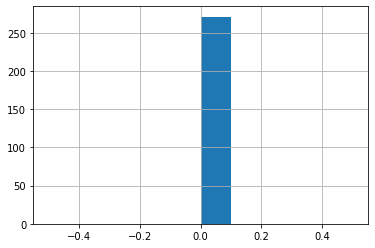

In [128]:
#figure out the nan per column
nans = clean_customers.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = clean_customers.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df['pct_nan'].hist()

In [129]:
clean_customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.000000,10.0,1.000000,1.303344,2.000000,1.079562,3.000000,0,5.000000,0,...,6,3.0,1.360294,1.0,6.000000,9.0,7.000000,3,1,4
1,1.588267,11.0,2.272799,1.303344,3.000000,1.079562,4.301758,44,3.677928,0,...,7,3.0,1.360294,1.0,4.251204,9.0,3.723133,3,1,4
2,1.588267,6.0,1.000000,1.303344,1.000000,1.079562,7.000000,21,2.000000,0,...,3,1.0,1.360294,2.0,6.000000,9.0,2.000000,3,2,4
3,1.000000,8.0,2.272799,1.303344,1.877631,1.079562,7.000000,15,2.000000,0,...,7,0.0,1.360294,1.0,4.251204,9.0,7.000000,1,1,4
4,1.588267,20.0,7.000000,1.303344,1.877631,1.079562,3.000000,31,6.000000,1,...,5,1.0,1.360294,2.0,2.000000,9.0,3.000000,1,1,3


In [130]:
clean_customers.to_csv('./data/cleaned/customer_subset.csv', index=False)

In [244]:
clean_customers = pd.read_csv('./data/cleaned/customer_subset.csv')

In [131]:
clean_customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.000000,10.0,1.000000,1.303344,2.000000,1.079562,3.000000,0,5.000000,0,...,6,3.0,1.360294,1.0,6.000000,9.0,7.000000,3,1,4
1,1.588267,11.0,2.272799,1.303344,3.000000,1.079562,4.301758,44,3.677928,0,...,7,3.0,1.360294,1.0,4.251204,9.0,3.723133,3,1,4
2,1.588267,6.0,1.000000,1.303344,1.000000,1.079562,7.000000,21,2.000000,0,...,3,1.0,1.360294,2.0,6.000000,9.0,2.000000,3,2,4
3,1.000000,8.0,2.272799,1.303344,1.877631,1.079562,7.000000,15,2.000000,0,...,7,0.0,1.360294,1.0,4.251204,9.0,7.000000,1,1,4
4,1.588267,20.0,7.000000,1.303344,1.877631,1.079562,3.000000,31,6.000000,1,...,5,1.0,1.360294,2.0,2.000000,9.0,3.000000,1,1,3


Let's replace the unknown (99) with the mean of the values (without included the 99)

# PCA

In [132]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

customers_scaled = scaler.fit_transform(clean_customers)
clean_customers = pd.DataFrame(customers_scaled, columns=clean_customers.columns)

In [133]:
#clean_customers['KBA13_ANZAHL_PKW'] = [0]*len(clean_customers['KBA13_ANZAHL_PKW'])

In [134]:
clean_customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,8.006030e-01,-0.971901,-7.187182e-01,2.360090e-15,2.077642e-01,-6.428448e-15,-7.159509e-01,-1.616831,0.735015,-0.218487,...,0.766546,1.322599,6.199258e-15,-1.122435,1.103670e+00,0.352235,1.818435e+00,0.362174,-0.776965,0.864527
1,4.317589e-16,-0.685877,-5.015325e-16,2.360090e-15,1.905612e+00,-6.428448e-15,-4.884872e-16,1.260622,0.000000,-0.218487,...,1.188950,1.322599,6.199258e-15,-1.122435,-5.605320e-16,0.352235,-2.464389e-16,0.362174,-0.776965,0.864527
2,4.317589e-16,-2.115999,-7.187182e-01,2.360090e-15,-1.490084e+00,-6.428448e-15,1.484000e+00,-0.243501,-0.932856,-0.218487,...,-0.500667,-0.666790,6.199258e-15,1.196861,1.103670e+00,0.352235,-9.562198e-01,0.362174,1.287059,0.864527
3,-1.143866e+00,-1.543950,-5.015325e-16,2.360090e-15,1.130994e-15,-6.428448e-15,1.484000e+00,-0.635881,-0.932856,-0.218487,...,1.188950,-1.661485,6.199258e-15,-1.122435,-5.605320e-16,0.352235,1.818435e+00,-1.349447,-0.776965,0.864527
4,4.317589e-16,1.888343,2.669335e+00,2.360090e-15,1.130994e-15,-6.428448e-15,-7.159509e-01,0.410465,1.290972,2.181418,...,0.344142,-0.666790,6.199258e-15,1.196861,-1.420742e+00,0.352235,-4.012888e-01,-1.349447,-0.776965,-0.056071


In [135]:
customers_pca = pca.transform(clean_customers)

In [163]:
customers_labels = kmeans.predict(customers_pca)

In [164]:
counts_customer = Counter(customers_labels)
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

In [165]:
counts_population = Counter(population_labels)
n_population = azdias_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

In [166]:
customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

In [167]:
all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

,% of data,Cluster,DataSet
8,7.412915,8,Customers Data
14,2.802475,14,Customers Data
10,3.175026,10,Customers Data
2,8.030180,2,Customers Data
0,3.661324,0,Customers Data
12,13.074740,12,Customers Data
6,13.723833,6,Customers Data
4,5.643562,4,Customers Data
3,4.422078,3,Customers Data
7,2.618809,7,Customers Data


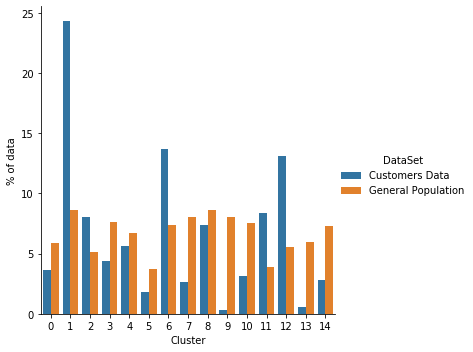

In [168]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

In [159]:
over_cluster = 4
print(f'general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')
pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)
pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)
pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

general population in cluster 4: 2.380639097744361%
customer population in cluster 4: 0.4716882683196627%



In [158]:
over_cluster = 2
print(f'general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')
pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)
pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)
pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

general population in cluster 2: 1.786340852130326%
customer population in cluster 2: 2.3453968651514203%



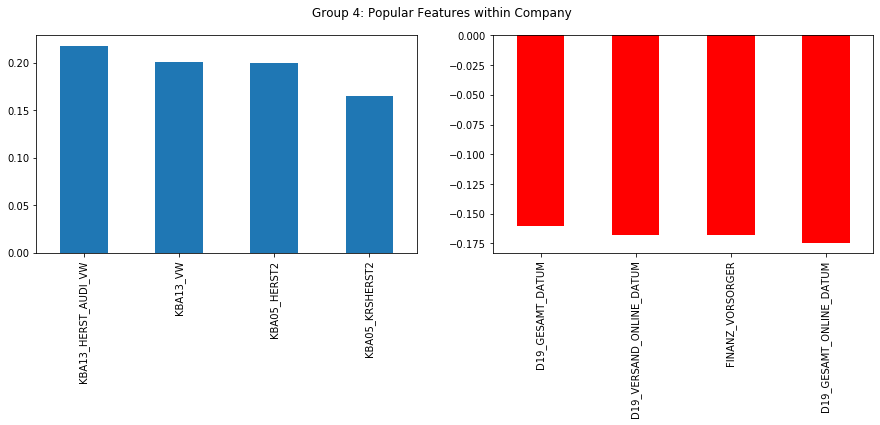

In [146]:
pca_feat_max = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=True).index[0]
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 4, customers)
plt.suptitle(f'Group {over_cluster}: Popular Features within Company');
plt.savefig('assets/cluster.png')

# RESULTS

### Popular with company 
- ALTER_HH = Main age within the household (High affinity)
- ALTERSKATEGORIE_GROB =  age classification through prename analysis  (High affinity)
- AGER_TYP = Best-ager Typology (Low Affinity)
- ALTER_HH = Best-ager Typology (Low Affinity)

In [ ]:
customers['AGER_TYP'].value_counts()